In [1]:
%matplotlib inline
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import wrf as wrfpy

#### Load in mmctools helper functions.
These are from the [a2e-mmc/mmctools repository](https://github.com/a2e-mmc/mmctools) (currently only in the dev branch). 

In [2]:
# manually add a2e-mmc repositories to PYTHONPATH if needed
#### If you have an 'a2e-mmc' directory under your $HOME
#module_path = os.path.join(os.environ['HOME'],'a2e-mmc')
#if module_path not in sys.path:
#    sys.path.append(module_path)
#### Alternatively, use a relative path to mmctools from this notebook 
####   (which lives in assessement/studies/perturbation_methods)
#### and assumes assessment and mmctools share some parent directory
sys.path.append('../../../')

In [3]:
from mmctools.helper_functions import calc_wind, theta

# Example: Assessment of Mesoscale Domain Results
Model data is the convective case from perturbations method study

In [4]:
TTUdata = '../../datasets/SWiFT/data/TTU_tilt_corrected_20131108-09.csv'

In [5]:
#modeldatadir = '/glade/scratch/jsauer/A2E-MMC/PMIC1/TEST_9_23_19/OUT_SET15_aligned/'
modeldatadir = '/scratch/equon/CBL_18Z-20Z'

In [6]:
# where to save outputs (e.g., figures)
outputdir = modeldatadir

## Load observation data
Load a processed TTU dataset for demonstration purposes. The dataset can be obtained by running the notebook `process_TTU_tower.ipynb` which can be found in the [a2e-mmc/assessment repository](https://github.com/a2e-mmc/assessment/tree/dev) (currently only in the dev branch)

In [7]:
df = pd.read_csv(TTUdata, parse_dates=True, index_col='datetime')
df.head()

,height,u,v,w,t,ts,p
datetime,,,,,,,
2013-11-08,0.9,-0.138929,2.637817,0.074016,284.794,289.410000,908.547754
2013-11-08,2.4,-0.601111,2.783204,0.487330,284.932,290.979994,908.723508
2013-11-08,4.0,0.416792,4.043940,0.295800,285.166,287.520000,908.215548
2013-11-08,10.1,-0.276479,5.227110,-0.418065,285.298,287.250000,907.611414
2013-11-08,16.8,0.034364,5.908367,-0.173836,285.414,287.610000,907.307654


## Compute derived metrics (wspd, wdir, theta) from the observation data
Do some additional data processing to obtain windspeed, wind direction and potential temperature using helper functions. 

In [8]:
# Calculate wind speed and direction
df['wspd'], df['wdir'] = calc_wind(df)

# Calculate potential temperature
df['theta'] = theta(df['t'],df['p'])

df.head(n=10)

,height,u,v,w,t,ts,p,wspd,wdir,theta
datetime,,,,,,,,,,
2013-11-08,0.9,-0.138929,2.637817,0.074016,284.794,289.410000,908.547754,2.641473,176.985128,292.713920
2013-11-08,2.4,-0.601111,2.783204,0.487330,284.932,290.979994,908.723508,2.847378,167.812564,292.839558
2013-11-08,4.0,0.416792,4.043940,0.295800,285.166,287.520000,908.215548,4.065362,185.884463,293.126923
2013-11-08,10.1,-0.276479,5.227110,-0.418065,285.298,287.250000,907.611414,5.234417,176.972263,293.318423
2013-11-08,16.8,0.034364,5.908367,-0.173836,285.414,287.610000,907.307654,5.908467,180.333242,293.465778
2013-11-08,47.3,-0.299790,7.742319,-0.449776,285.698,290.000000,902.911430,7.748121,177.782562,294.166144
2013-11-08,74.7,-0.383357,9.024248,-0.042725,285.784,291.070000,900.655410,9.032387,177.567492,294.465306
2013-11-08,116.5,0.176337,9.460641,-0.050773,285.362,287.170000,896.267652,9.462284,181.067816,294.441453
2013-11-08,158.2,0.533686,9.701320,-0.329569,285.114,289.320000,892.083416,9.715988,183.148765,294.579540


## Calculate 30-minute rolling means
Use pandas intrinsics pivot, resample, stack to find the 30-minute means of the derived metrics for the SWiFT, TTU tower observations.

In [9]:
df30 = df.pivot(columns='height',values=['u','v','w','wspd','wdir','theta']).resample('30min').mean().stack()
df30.reset_index(inplace=True)
df30.set_index(['datetime'],inplace=True)

## Load mesoscale modeling results data 

In [10]:
modelHours = [16,18,20]  # to plot

modelFiles = []
mod_legStrs = []
for modelHour in modelHours:
    modTTUdata = 'wrfout_d01_2013-11-08_{:d}:00:00'.format(modelHour)
    mod_legStrs.append('Mod-{:d}Z'.format(modelHour))
    modelFiles.append(os.path.join(modeldatadir, modTTUdata))
modelFiles

['/scratch/equon/CBL_18Z-20Z/wrfout_d01_2013-11-08_16:00:00',
 '/scratch/equon/CBL_18Z-20Z/wrfout_d01_2013-11-08_18:00:00',
 '/scratch/equon/CBL_18Z-20Z/wrfout_d01_2013-11-08_20:00:00']

In [11]:
u = []
v = []
w = []
z = []
theta = []
for modelFile in modelFiles:
    ncfile = Dataset(modelFile)
    U = wrfpy.getvar(ncfile, "U")
    V = wrfpy.getvar(ncfile, "V")
    W = wrfpy.getvar(ncfile, "W")
    Z = wrfpy.getvar(ncfile, "PH")+wrfpy.getvar(ncfile, "PHB")/9.8
    u.append(wrfpy.destagger(U,stagger_dim=2,meta=True))
    v.append(wrfpy.destagger(V,stagger_dim=1,meta=True))
    w.append(wrfpy.destagger(W,stagger_dim=0,meta=True))
    z.append(wrfpy.destagger(Z,stagger_dim=0,meta=True))
    theta.append(wrfpy.getvar(ncfile, "THM")) #theta is cell-centered in WRF

In [12]:
ws = []
wdir = []
for element in range(len(u)):
    ws.append(np.sqrt(np.square(u[element])+np.square(v[element])))
    wdir.append(180. + np.arctan2(u[element],v[element])*180./np.pi)
### Insert Pandas magic here to make a dataframe like df(from Obs) but for dfm (from Mod) as columns[u,v,w,wspd,wdir,theta] and rows(heights=z)
### Then I think we can just use plotting.py


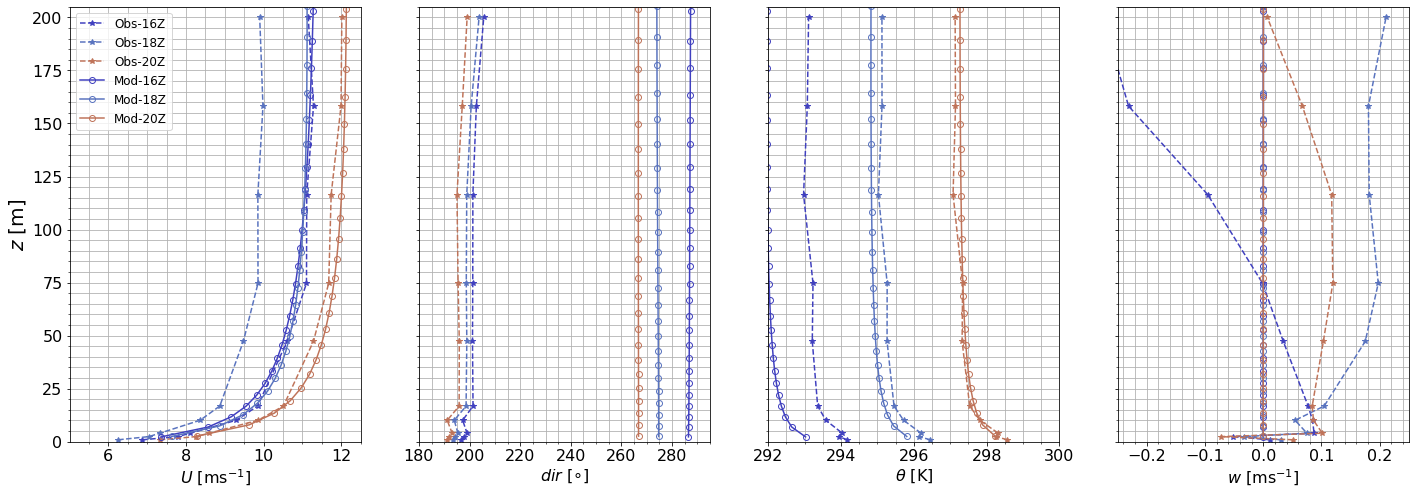

In [13]:
fntSize=16
plt.rcParams['xtick.labelsize']=fntSize
plt.rcParams['ytick.labelsize']=fntSize
numPlotsX=1
numPlotsY=4
fig,ax = plt.subplots(numPlotsX,numPlotsY,sharey=True,sharex=False,figsize=(24,8))

# plot-windspeed
im = ax[0].plot(df30['wspd'].loc['2013-11-08 16:00:00'],df30['height'].loc['2013-11-08 16:00:00'],'*--',color=[0.25,0.25,0.75],label='Obs-16Z')
im = ax[0].plot(df30['wspd'].loc['2013-11-08 18:00:00'],df30['height'].loc['2013-11-08 18:00:00'],'*--',color=[0.35,0.45,0.75],label='Obs-18Z')
im = ax[0].plot(df30['wspd'].loc['2013-11-08 20:00:00'],df30['height'].loc['2013-11-08 20:00:00'],'*--',color=[0.75,0.45,0.35],label='Obs-20Z')
im = ax[0].plot(ws[0].mean(axis=(1,2)),z[0].mean(axis=(1,2)),'o-',color=[0.25,0.25,0.75],markerfacecolor="None",label=mod_legStrs[0])
im = ax[0].plot(ws[1].mean(axis=(1,2)),z[1].mean(axis=(1,2)),'o-',color=[0.35,0.45,0.75],markerfacecolor="None",label=mod_legStrs[1])
im = ax[0].plot(ws[2].mean(axis=(1,2)),z[2].mean(axis=(1,2)),'o-',color=[0.75,0.45,0.35],markerfacecolor="None",label=mod_legStrs[2])


# plot-wind_dir.
im = ax[1].plot(df30['wdir'].loc['2013-11-08 16:00:00'],df30['height'].loc['2013-11-08 16:00:00'],'*--',color=[0.25,0.25,0.75],label='Obs-16Z')
im = ax[1].plot(df30['wdir'].loc['2013-11-08 18:00:00'],df30['height'].loc['2013-11-08 18:00:00'],'*--',color=[0.35,0.45,0.75],label='Obs-18Z')
im = ax[1].plot(df30['wdir'].loc['2013-11-08 20:00:00'],df30['height'].loc['2013-11-08 20:00:00'],'*--',color=[0.75,0.45,0.35],label='Obs-20Z')
im = ax[1].plot(wdir[0].mean(axis=(1,2)),z[0].mean(axis=(1,2)),'o-',color=[0.25,0.25,0.75],markerfacecolor="None",label=mod_legStrs[0])
im = ax[1].plot(wdir[1].mean(axis=(1,2)),z[1].mean(axis=(1,2)),'o-',color=[0.35,0.45,0.75],markerfacecolor="None",label=mod_legStrs[1])
im = ax[1].plot(wdir[2].mean(axis=(1,2)),z[2].mean(axis=(1,2)),'o-',color=[0.75,0.45,0.35],markerfacecolor="None",label=mod_legStrs[2])


# plot-theta
im = ax[2].plot(df30['theta'].loc['2013-11-08 16:00:00'],df30['height'].loc['2013-11-08 16:00:00'],'*--',color=[0.25,0.25,0.75],label='Obs-16Z')
im = ax[2].plot(df30['theta'].loc['2013-11-08 18:00:00'],df30['height'].loc['2013-11-08 18:00:00'],'*--',color=[0.35,0.45,0.75],label='Obs-18Z')
im = ax[2].plot(df30['theta'].loc['2013-11-08 20:00:00'],df30['height'].loc['2013-11-08 20:00:00'],'*--',color=[0.75,0.45,0.35],label='Obs-20Z')
im = ax[2].plot(theta[0].mean(axis=(1,2))+300,z[0].mean(axis=(1,2)),'o-',color=[0.25,0.25,0.75],markerfacecolor="None",label=mod_legStrs[0])
im = ax[2].plot(theta[1].mean(axis=(1,2))+300,z[1].mean(axis=(1,2)),'o-',color=[0.35,0.45,0.75],markerfacecolor="None",label=mod_legStrs[1])
im = ax[2].plot(theta[2].mean(axis=(1,2))+300,z[2].mean(axis=(1,2)),'o-',color=[0.75,0.45,0.35],markerfacecolor="None",label=mod_legStrs[2])

# plot-w
im = ax[3].plot(df30['w'].loc['2013-11-08 16:00:00'],df30['height'].loc['2013-11-08 16:00:00'],'*--',color=[0.25,0.25,0.75],label='Obs-16Z')
im = ax[3].plot(df30['w'].loc['2013-11-08 18:00:00'],df30['height'].loc['2013-11-08 18:00:00'],'*--',color=[0.35,0.45,0.75],label='Obs-18Z')
im = ax[3].plot(df30['w'].loc['2013-11-08 20:00:00'],df30['height'].loc['2013-11-08 20:00:00'],'*--',color=[0.75,0.45,0.35],label='Obs-20Z')
im = ax[3].plot(w[0].mean(axis=(1,2)),z[0].mean(axis=(1,2)),'o-',color=[0.25,0.25,0.75],markerfacecolor="None",label=mod_legStrs[0])
im = ax[3].plot(w[1].mean(axis=(1,2)),z[1].mean(axis=(1,2)),'o-',color=[0.35,0.45,0.75],markerfacecolor="None",label=mod_legStrs[1])
im = ax[3].plot(w[2].mean(axis=(1,2)),z[2].mean(axis=(1,2)),'o-',color=[0.75,0.45,0.35],markerfacecolor="None",label=mod_legStrs[2])

ax[0].set_ylabel(r'$z$ $[\mathrm{m}]$',fontsize=20)

#ax[0].set_ylim([0,1700])
#ax[0].set_xlim([5,17.5])

ax[0].set_ylim([0,205])
ax[0].set_xlim([5,12.5])
ax[1].set_xlim([180,295])
ax[2].set_xlim([292,300])
ax[3].set_xlim([-0.25,0.25])

ax[0].legend(fontsize=12)
ax[0].set_xlabel(r'$U$ $[\mathrm{ms^{-1}}]$',fontsize=fntSize)
ax[0].minorticks_on()
ax[0].grid(which='both')

ax[1].set_xlabel(r'$dir$ $[\mathrm{\circ}]$',fontsize=fntSize)
ax[1].minorticks_on()
ax[1].grid(which='both')

ax[2].set_xlabel(r'$\theta$ $[\mathrm{K}]$',fontsize=fntSize)
ax[2].minorticks_on()
ax[2].grid(which='both')

ax[3].set_xlabel(r'$w$ $[\mathrm{ms^{-1}}]$',fontsize=fntSize)
ax[3].minorticks_on()
ax[3].grid(which='both')


## Save mesoscale modeling results data 

In [14]:
saveFileName = os.path.join(outputdir, 'Profiles-PMIC1_d01_test.png')
print('Writing out',saveFileName)
fig.savefig(saveFileName, dpi=200, bbox_inches='tight')

Writing out /scratch/equon/CBL_18Z-20Z/Profiles-PMIC1_d01_test.png
